# Sentiment Analysis of Amazon Reviews
## -	an NLP exercise in Python


### Introduction
In this exercise, we are going to analyze Amazon fine food reviews and build text classification models to classify the text of the reviews into sentiment categories. I am using the Amazon fine food review dataset available [here]( https://www.kaggle.com/snap/amazon-fine-food-reviews), which contains 568,454 food reviews Amazon users left up to October 2012. We are going to implement these 3 main components of a text classification pipeline:
1. Dataset Preparation
2. Feature Engineering
3. Model Training

### 1. Dataset Preparation
The first step is to load the dataset and perform basic pre-processing, such as tokenizing, removing stop words and other noise words. We also explore the sentiment distribution and find out what the most common n-grams are for positive and negative reviews. The dataset is then splitted into train and test sets to get ready for the next step.

In [1]:
# Before started: install and import all the libraries we need:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble

In [2]:
# load the dataset
data_path = "~/Documents/python_exercise/amazon-fine-food-reviews/Reviews.csv"
data = pd.read_csv(data_path)
# show dataset info
data.info()
# to shorten run time, randomly select 10000 rows of data from the whole datast for this exercise
data = data.sample(10000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


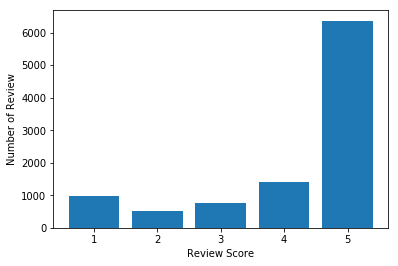

In [3]:
# exploring the data
# review score distribution
data.Score.value_counts()
Sentiment_count = data.groupby('Score').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['Text'])
plt.xlabel('Review Score')
plt.ylabel('Number of Review')
plt.show()

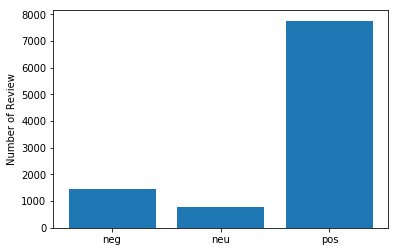

In [4]:
# label the data: add a column "Label" to category reviews to negtive, neutral, and positive
# by categorizing score 4 and 5 to "neg", score 3 to "neu", and score 1 and 2 to "pos"
data['Label'] = 'neu'
data.loc[data['Score']>3,'Label']='pos'
data.loc[data['Score']<3,'Label']='neg'

# label distribution
data.Label.value_counts()
Sentiment_count=data.groupby('Label').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['Text'])
plt.ylabel('Number of Review')
plt.show()

In [5]:
# pre-processing of the data, including: 
# removing URLs, line breakers, tokenizing the text, removing stop words
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

def process_text(reviews):
    tokens = []
    for line in reviews:
        line = re.sub(r"http\S+", "",line)
        line = re.sub("<br />", "",line)
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    return tokens

In [6]:
# finding the most common n-grams (the combination of N words) for positive reviews and negative reviews
# the most common n-grams for positive reviews
pos_lines = list(data[data.Label == 'pos'].Text)
pos_tokens = process_text(pos_lines)
ngs = nltk.ngrams(pos_tokens,3)
pos_freq = nltk.FreqDist(ngs)
pos_freq.most_common(20)

[(('local', 'grocery', 'store'), 47),
 (('would', 'highly', 'recommend'), 38),
 (('highly', 'recommend', 'product'), 34),
 (('5', 'hour', 'energy'), 30),
 (('goes', 'long', 'way'), 27),
 (('like', 'peanut', 'butter'), 25),
 (('health', 'food', 'store'), 23),
 (('fructose', 'corn', 'syrup'), 23),
 (('high', 'fructose', 'corn'), 22),
 (('would', 'recommend', 'anyone'), 22),
 (('decided', 'give', 'try'), 21),
 (('tried', 'many', 'different'), 20),
 (('chocolate', 'chip', 'cookies'), 20),
 (('amazon', 'subscribe', 'save'), 19),
 (('2', 'year', 'old'), 18),
 (('earl', 'grey', 'tea'), 18),
 (('great', 'cup', 'coffee'), 17),
 (('give', '5', 'stars'), 17),
 (('great', 'product', 'great'), 17),
 (('little', 'goes', 'long'), 17)]

In [7]:
# the most common n-grams for negative reviews
neg_lines = list(data[data.Label == 'neg'].Text)
neg_lines_new = [re.sub(r"http\S+", "",line) for line in neg_lines]
neg_tokens = process_text(neg_lines_new)
ngs = nltk.ngrams(neg_tokens,3)
neg_freq = nltk.FreqDist(ngs)
neg_freq.most_common(20)

[(('high', 'fructose', 'corn'), 12),
 (('fructose', 'corn', 'syrup'), 12),
 (('local', 'grocery', 'store'), 10),
 (('eating', 'real', 'food'), 8),
 (('stash', 'green', 'tea'), 7),
 (('12', 'ounce', 'pouches'), 7),
 (('ounce', 'pouches', 'pack'), 7),
 (('pouches', 'pack', '6'), 7),
 (('try', 'something', 'else'), 6),
 (('first', 'two', 'ingredients'), 6),
 (('got', 'bad', 'batch'), 6),
 (('non', 'organic', 'stash'), 6),
 (('organic', 'stash', 'green'), 6),
 (('really', 'looking', 'forward'), 6),
 (('back', 'drawing', 'board'), 6),
 (('pack', '6', 'href'), 6),
 (('6', 'href', 'naked'), 6),
 (('ounce', 'boxes', 'pack'), 6),
 (('tastes', 'nothing', 'like'), 5),
 (('5', 'hour', 'energy'), 5)]

In [8]:
# split the dataset into training and test datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(data['Text'], data['Label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

### 2. Feature Engineering
The next step is the Feature Engineering in which the raw dataset is transformed into flat features which can be used in a machine learning model. This step also includes the process of creating new features from the existing data.

In [9]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(data['Text'])

# transform the training and testation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xtest_count =  count_vect.transform(test_x)

In [10]:
# TF-IDF Vectors as features:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(data['Text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(data['Text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_x)

### 3. Model Building
The final step is the Model Building step in which a machine learning model is trained on a labelled dataset.

In [11]:
# a function to train a model and and output accuracy score 
def train_model(classifier, feature_vector_train, label, feature_vector_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on test dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

In [12]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xtest_count)
print ("Accuracy of Naive Bayes Model on Count Vectors is ", accuracy*100, "%")

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xtest_tfidf)
print ("Accuracy of Naive Bayes Model on WordLevel TF-IDF is ", accuracy*100, "%")

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("Accuracy of Naive Bayes model on N-Gram Vectors is ", accuracy*100, "%")

Accuracy of Naive Bayes Model on Count Vectors is  81.32000000000001 %
Accuracy of Naive Bayes Model on WordLevel TF-IDF is  77.88000000000001 %
Accuracy of Naive Bayes model on N-Gram Vectors is  79.52 %


In [13]:
# ignore warning messages
warnings.simplefilter('ignore')

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("Accuracy of SVM model on Count Vectors is ", accuracy*100, "%")

# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xtest_count)
print ("Accuracy of Random Forest model on Count Vectors is ", accuracy*100, "%")

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xtest_tfidf)
print ("Accuracy of Random Forest model on WordLevel TF-IDF is ", accuracy*100, "%")

Accuracy of SVM model on Count Vectors is  77.56 %
Accuracy of Random Forest model on Count Vectors is  79.03999999999999 %
Accuracy of Random Forest model on WordLevel TF-IDF is  79.28 %


In [15]:
warnings.simplefilter('ignore')
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xtest_count)
print ("Accuracy of Logistic Regression model on Count Vectors is ", accuracy*100, "%")

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xtest_tfidf)
print ("Accuracy of Logistic Regression model on WordLevel TF-IDF is ", accuracy*100, "%")

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("Accuracy of Logistic Regression model on N-Gram Vectors is ", accuracy*100, "%")

Accuracy of Logistic Regression model on Count Vectors is  83.67999999999999 %
Accuracy of Logistic Regression model on WordLevel TF-IDF is  81.52000000000001 %
Accuracy of Logistic Regression model on N-Gram Vectors is  80.08 %


### Summary
In this exercise, we looked at how to prepare and explore a text dataset, including cleaning the data, finding most common n-grams, and creating training and validation dataset. We performed different types of feature engineering like Count Vector and TF-IDF, and finally trained a variety of classifiers like Naive Bayes/ Logistic regression/ SVM/ Random Forest. 
For future study, there are different ways to improve the performance of text classifiers, such as further text cleaning, combining different algorithmic classifiers, and tuning the model paramters.